# Car Price prediction
# Прогнозирование стоимости автомобиля по характеристикам

In [2349]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoost, CatBoostRegressor, Pool
from sklearn.preprocessing import LabelEncoder

In [2350]:
import numpy as np
import pandas as pd 


from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeRegressor
from pandas import Series

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

from sklearn.metrics import recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.base import clone
import datetime
from datetime import datetime, timedelta
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from pprint import pprint

In [2351]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [2352]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [2353]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [2354]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [2355]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-from-autoru//' # подключить к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [2356]:
!ls '../input'

parsing-from-autoru  sf-dst-car-price-prediction


In [2357]:
train = pd.read_csv(DIR_TRAIN+'auto_421.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')
train.shape

(49532, 27)

In [2358]:
test.shape

(34686, 32)

In [2359]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49532 entries, 0 to 49531
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              49532 non-null  object 
 1   brand                 49532 non-null  object 
 2   car_url               49532 non-null  object 
 3   color                 49532 non-null  object 
 4   complectation_dict    49532 non-null  object 
 5   description           49532 non-null  object 
 6   engineDisplacement    49532 non-null  object 
 7   enginePower           49532 non-null  object 
 8   fuelType              49532 non-null  object 
 9   image                 49532 non-null  object 
 10  mileage               49532 non-null  int64  
 11  modelDate             49532 non-null  int64  
 12  model_name            49532 non-null  object 
 13  name                  49532 non-null  object 
 14  numberOfDoors         49532 non-null  int64  
 15  parsing_unixtime   

In [2360]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Data Preprocessing

In [2361]:
# ... 

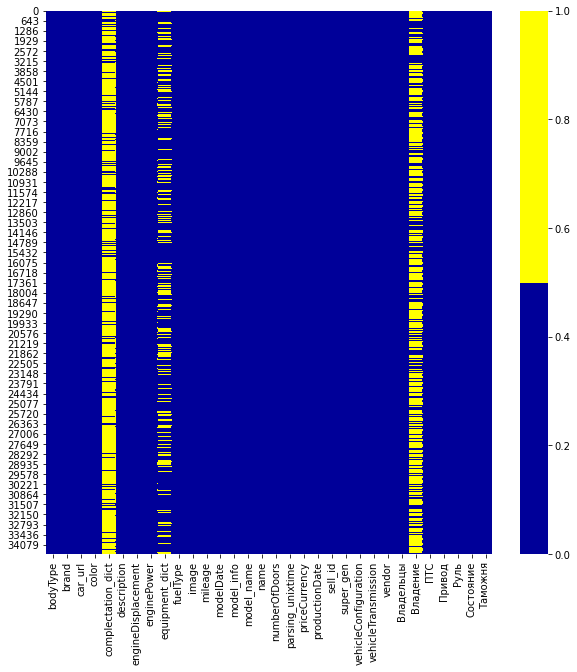

In [2362]:
# Посмотрим с помощью тепловой карты на пропущенные значения
cols = test.columns
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(test[cols].isnull(), cmap=sns.color_palette(colours))

In [2363]:
test.isnull().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

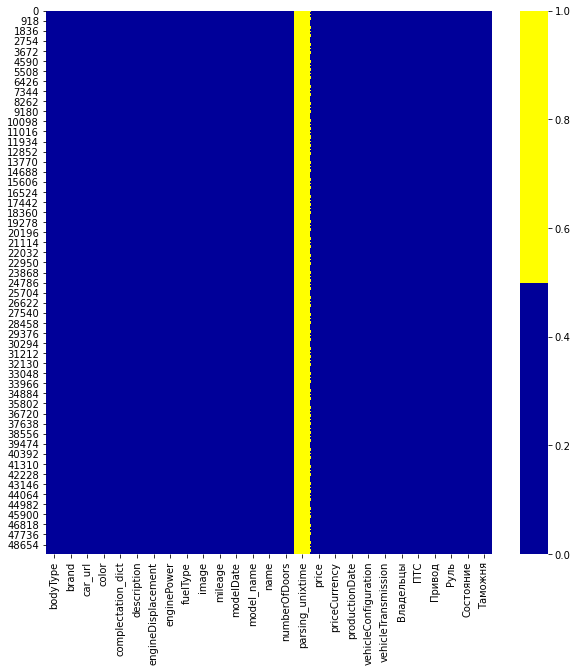

In [2364]:
# Посмотрим с помощью тепловой карты на пропущенные значения
cols = train.columns
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(train[cols].isnull(), cmap=sns.color_palette(colours))

In [2365]:
train.isnull().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict          0
description                 0
engineDisplacement          0
enginePower                 0
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime        49532
price                       0
priceCurrency               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
Владельцы                   0
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [2366]:
print(train['price'].min())

25000


In [2367]:
print(train['price'].max())

31500000


In [2368]:
train.price.describe()

count    4.953200e+04
mean     1.445504e+06
std      1.523078e+06
min      2.500000e+04
25%      5.690000e+05
50%      9.650000e+05
75%      1.797000e+06
max      3.150000e+07
Name: price, dtype: float64

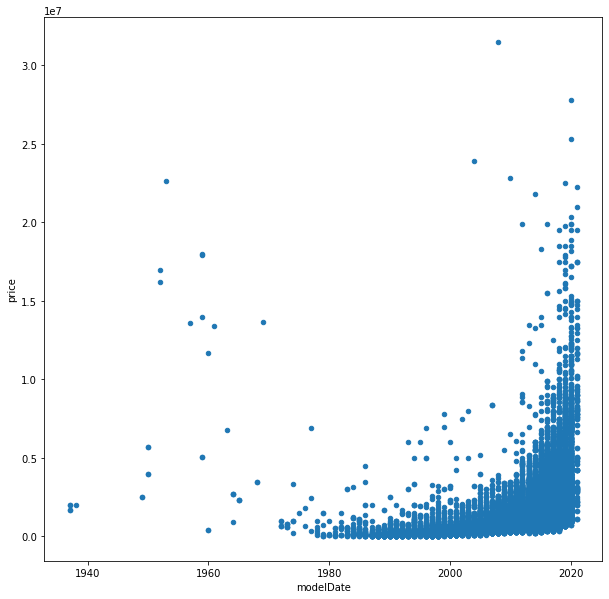

In [2369]:
train.plot(kind='scatter', y='price', x='modelDate')

965000.0

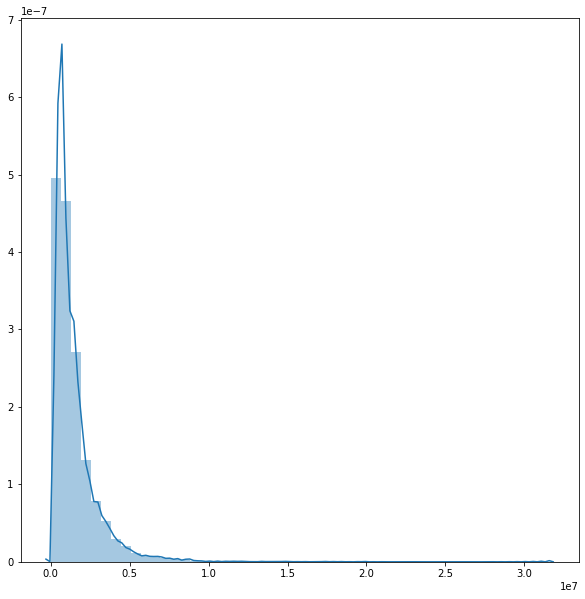

In [2370]:
sns.distplot(train.price.values)
np.median(train.price.values)

### 1. bodyType - тип кузова

In [2371]:
print(train['bodyType'].unique())

['внедорожник 5 дв.' 'седан' 'хэтчбек 5 дв.' 'купе' 'кабриолет' 'минивэн'
 'компактвэн' 'пикап двойная кабина' 'лифтбек' 'универсал 5 дв.' 'фургон'
 'хэтчбек 3 дв.' 'пикап одинарная кабина' 'внедорожник 3 дв.'
 'купе-хардтоп' 'родстер' 'внедорожник открытый' 'лимузин' 'седан 2 дв.'
 'микровэн' 'пикап полуторная кабина' 'седан-хардтоп' 'тарга'
 'универсал 3 дв.']


In [2372]:
print(test['bodyType'].unique())

['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон']


В test есть 1 "фастбек", которого нет в train, заменим его на "седан".

In [2373]:
test.loc[test['bodyType'] == 'фастбек', 'bodyType'] = 'седан'

### 2. brand

In [2374]:
print(train['brand'].unique())

['INFINITI' 'VOLKSWAGEN' 'NISSAN' 'MERCEDES' 'LEXUS' 'BMW' 'TOYOTA'
 'MITSUBISHI' 'SKODA' 'AUDI' 'VOLVO' 'HONDA']


In [2375]:
print(test['brand'].unique())

['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


Бренды отобраны одинаковые

### 3. car_url и 11. image

Для анализа эти признаки не нужны. Удаляем их.

In [2376]:
test = test.drop(['car_url'], axis=1)
train = train.drop(['car_url'], axis=1)
test = test.drop(['image'], axis=1)
train = train.drop(['image'], axis=1)

### 4. color - цвет автомобиля

In [2377]:
print(train['color'].unique())

['чёрный' 'красный' 'серый' 'белый' 'синий' 'серебристый' 'коричневый'
 'пурпурный' 'бежевый' 'оранжевый' 'фиолетовый' 'голубой' 'зелёный'
 'золотистый' 'жёлтый' 'розовый']


In [2378]:
print(test['color'].unique())

['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']


В test и train одинаковый набор цветов авто

In [2379]:
train_color = round(train.color.value_counts() / len(train)*100, 2)
print(train_color)

чёрный         29.82
белый          21.17
серый          12.66
серебристый     9.76
синий           9.56
коричневый      5.08
красный         4.11
зелёный         2.10
бежевый         1.83
голубой         1.05
пурпурный       0.74
золотистый      0.64
жёлтый          0.62
фиолетовый      0.44
оранжевый       0.40
розовый         0.02
Name: color, dtype: float64


In [2380]:
test_color = round(test.color.value_counts() / len(test)*100, 2)
print(test_color)

чёрный         31.74
белый          17.68
серебристый    11.86
серый          11.49
синий           9.48
красный         4.41
коричневый      4.33
зелёный         2.74
бежевый         1.84
голубой         1.32
золотистый      0.77
пурпурный       0.73
фиолетовый      0.63
жёлтый          0.56
оранжевый       0.38
розовый         0.04
Name: color, dtype: float64


In [2381]:
# посмотрим сколько автомобилей и каких цветов
test.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

### 5. complectation_dict - комплектация и 9. equipment_dict - оснащение

In [2382]:
temp_train = train.query('brand == "VOLKSWAGEN" & model_name == "PASSAT"')[
    ['bodyType', 'name','complectation_dict']]
temp_train

,bodyType,name,complectation_dict
676,седан,Volkswagen Passat B5,[]
711,седан,Volkswagen Passat B7,"['Круиз-контроль', 'Мультифункциональное рулев..."
719,универсал 5 дв.,Volkswagen Passat B7,"['Круиз-контроль', 'Электропривод зеркал', 'Эл..."
726,универсал 5 дв.,Volkswagen Passat B8 Alltrack,"['Тонированные стекла', 'Вентиляция передних с..."
735,универсал 5 дв.,Volkswagen Passat B6,"['Защита картера', 'Антипробуксовочная система..."
...,...,...,...
15089,универсал 5 дв.,Volkswagen Passat B4,"['Тонированные стекла', 'Складывающееся заднее..."
15090,седан,Volkswagen Passat B6,"['Антипробуксовочная система (ASR)', 'Антиблок..."
15099,седан,Volkswagen Passat B5 Рестайлинг,"['Электростеклоподъёмники задние', 'Электросте..."
15101,седан,Volkswagen Passat B6,"['Круиз-контроль', 'Усилитель руля', 'Климат-к..."


In [2383]:
temp_test = test.query('brand == "VOLKSWAGEN" & model_name == "PASSAT"')[
    ['bodyType', 'name','complectation_dict','equipment_dict']]
temp_test

,bodyType,name,complectation_dict,equipment_dict
23142,седан,1.8 AMT (152 л.с.),"{""id"":""7150236"",""name"":""Comfortline"",""availabl...","{""tinted-glass"":true,""esp"":true,""multi-wheel"":..."
23154,седан,1.8 AMT (152 л.с.),NaN,"{""cruise-control"":true,""asr"":true,""tinted-glas..."
23164,седан,1.8 MT (152 л.с.),NaN,"{""cruise-control"":true,""asr"":true,""tinted-glas..."
23180,универсал 5 дв.,1.8 MT (125 л.с.),NaN,"{""steel-wheels"":true,""airbag-driver"":true,""aux..."
23181,седан,1.4 AMT (150 л.с.),NaN,"{""cruise-control"":true,""asr"":true,""esp"":true,""..."
...,...,...,...,...
34017,универсал 5 дв.,1.6 MT (72 л.с.),NaN,NaN
34018,седан,2.0 AT (150 л.с.),NaN,"{""front-seat-support"":true,""rain-sensor"":true,..."
34028,седан,1.8 MT (150 л.с.),NaN,NaN
34030,универсал 5 дв.,1.9d MT (75 л.с.),NaN,NaN


In [2384]:
#complectation_dict и equipment_dict разной структуры, в test complectation_dict много пропусков. Удаляю эти признаки
test = test.drop(['complectation_dict'], axis=1)
train = train.drop(['complectation_dict'], axis=1)
test = test.drop(['equipment_dict'], axis=1)

### 6. description

Текст объявления пока оставляем, можно попробовать проанализировать текст.

### 7. engineDisplacement - объем двигателя

In [2385]:
print(train['engineDisplacement'].unique())

['5.6 LTR' '2.5 LTR' '3.0 LTR' '5.0 LTR' '3.7 LTR' '2.0 LTR' '3.5 LTR'
 '4.5 LTR' '1.6 LTR' '3.3 LTR' '1.5 LTR' '1.8 LTR' '1.4 LTR' '1.2 LTR'
 '3.2 LTR' '3.6 LTR' '1.9 LTR' '2.8 LTR' '4.2 LTR' '4.1 LTR' ' LTR'
 '1.3 LTR' '2.3 LTR' '2.1 LTR' '1.0 LTR' '4.0 LTR' '2.4 LTR' '4.9 LTR'
 '2.9 LTR' '1.7 LTR' '6.0 LTR' '3.8 LTR' '2.2 LTR' '4.4 LTR' '2.6 LTR'
 '0.7 LTR' '2.7 LTR' '4.8 LTR' '5.5 LTR' '4.7 LTR' '5.4 LTR' '6.2 LTR'
 '5.8 LTR' '4.3 LTR' '3.4 LTR' '4.6 LTR' '5.7 LTR' '6.6 LTR' '0.6 LTR'
 '3.9 LTR' '1.1 LTR' '5.2 LTR' '3.1 LTR' '6.3 LTR' '5.9 LTR']


In [2386]:
print(test['engineDisplacement'].unique())

['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3 LTR' '2.1 LTR' '2.6 LTR' ' LTR' '3.5 LTR'
 '1.7 LTR' '0.7 LTR' '4.4 LTR' '4.8 LTR' '5.4 LTR' '6.6 LTR' '4.9 LTR'
 '3.8 LTR' '3.4 LTR' '3.9 LTR' '4.6 LTR' '5.6 LTR' '4.5 LTR' '5.5 LTR'
 '6.2 LTR' '4.7 LTR' '4.3 LTR' '5.8 LTR' '5.3 LTR' '5.7 LTR']


In [2387]:
# и меняем тип переменной на числовой
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x.replace(' LTR', ''))
train['engineDisplacement'] = pd.to_numeric(train['engineDisplacement'], errors='coerce')
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x.replace(' LTR', ''))
test['engineDisplacement'] = pd.to_numeric(test['engineDisplacement'], errors='coerce')

In [2388]:
print(train['engineDisplacement'].unique())

[5.6 2.5 3.  5.  3.7 2.  3.5 4.5 1.6 3.3 1.5 1.8 1.4 1.2 3.2 3.6 1.9 2.8
 4.2 4.1 nan 1.3 2.3 2.1 1.  4.  2.4 4.9 2.9 1.7 6.  3.8 2.2 4.4 2.6 0.7
 2.7 4.8 5.5 4.7 5.4 6.2 5.8 4.3 3.4 4.6 5.7 6.6 0.6 3.9 1.1 5.2 3.1 6.3
 5.9]


In [2389]:
print(test['engineDisplacement'].unique())

[1.2 1.6 1.8 2.  1.4 1.3 1.  3.6 1.5 1.9 2.8 1.1 2.5 4.2 3.  4.  5.9 2.7
 3.1 2.4 5.2 3.2 4.1 6.3 2.3 6.  2.2 3.7 2.9 5.  3.3 2.1 2.6 nan 3.5 1.7
 0.7 4.4 4.8 5.4 6.6 4.9 3.8 3.4 3.9 4.6 5.6 4.5 5.5 6.2 4.7 4.3 5.8 5.3
 5.7]


In [2390]:
# посмотрим на строки с пропусками значения engineDisplacement в train
engineDisplacement_null = train[train.engineDisplacement.isnull()]
pd.DataFrame(engineDisplacement_null.brand.value_counts())

,brand
NISSAN,104
BMW,24
VOLKSWAGEN,12
AUDI,3
MERCEDES,3
MITSUBISHI,1
TOYOTA,1


In [2391]:
# 'электро  Емкость батареи, кВт⋅ч40
engineDisplacement_null[engineDisplacement_null.brand == 'NISSAN'].model_name.value_counts()

LEAF    104
Name: model_name, dtype: int64

In [2392]:
# 'электро  Емкость батареи, кВт⋅ч42
engineDisplacement_null[engineDisplacement_null.brand == 'BMW'].model_name.value_counts()

I3    24
Name: model_name, dtype: int64

Пропуски в основном по электромобилям, и там поставим условный объем двигателя, обработаем вместе с обработкой мощности

### 8. enginePower - мощность двигателя

In [2393]:
print(train['enginePower'].unique())

['405 N12' '222 N12' '238 N12' '400 N12' '333 N12' '211 N12' '262 N12'
 '328 N12' '221 N12' '265 N12' '420 N12' '307 N12' '325 N12' '156 N12'
 '280 N12' '315 N12' '313 N12' '283 N12' '302 N12' '249 N12' '231 N12'
 '340 N12' '260 N12' '320 N12' '306 N12' '243 N12' '284 N12' '168 N12'
 '330 N12' '309 N12' '278 N12' '149 N12' '272 N12' '303 N12' '109 N12'
 '193 N12' '295 N12' '125 N12' '150 N12' '122 N12' '180 N12' '105 N12'
 '140 N12' '102 N12' '235 N12' '110 N12' '204 N12' '220 N12' '170 N12'
 '240 N12' '152 N12' '131 N12' '85 N12' '84 N12' '120 N12' '224 N12'
 '200 N12' '174 N12' '115 N12' '80 N12' '245 N12' '90 N12' '75 N12'
 '86 N12' '160 N12' '335 N12' '60 N12' '101 N12' '210 N12' '68 N12'
 '136 N12' '190 N12' '50 N12' '310 N12' '55 N12' '100 N12' '300 N12'
 '163 N12' '130 N12' '95 N12' '42 N12' '256 N12' '48 N12' '67 N12'
 '275 N12' '72 N12' '241 N12' '250 N12' '129 N12' '44 N12' '70 N12'
 '78 N12' '104 N12' '69 N12' '199 N12' '40 N12' '64 N12' '46 N12'
 '116 N12' '350 N12' '57 N12

In [2394]:
print(test['enginePower'].unique())

['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12' '80 N12' '68 N12'
 '160 N12' '115 N12' '280 N12' '53 N12' '60 N12' '143 N12' '42 N12'
 '101 N12' '58 N12' '193 N12' '79 N12' '30 N12' '100 N12' '50 N12'
 '163 N12' '225 N12' '420 N12' '211 N12' '245 N12' '560 N12' '500 N12'
 '249 N12' '450 N12' '605 N12' '250 N12' '354 N12' '120 N12' '290 N12'
 '230 N12' '350 N12' '204 N12' '255 N12' '340 N12' '177 N12' '272 N12'
 '372 N12' '210 N12' '130 N12' '300 N12' '190 N12' '239 N12' '435 N12'
 '333 N12' '271 N12' '326 N12' '238 N12' '310 N12' '233 N12' '252 N12'
 '133 N12' '460 N12' '520 N12' '400 N12' '525 N12' '367 N12' '265 N12'
 '550 N12' '580 N12' '88 N12' '165 N12' '430 N12' '335 N12' '174 N12'
 '224 N12' '136 N12' '256 N12' '338 N12' '112 N12' '218 N12' '360 N12'
 '93 N12' '182 N12' '113 N12' '240 N12' '270 N12' '137 N12' '155 N12'
 '61 N12' '254

In [2395]:
train['enginePower'] = train['enginePower'].apply(
    lambda x: int(x.replace(' N12', '')))
test['enginePower'] = test['enginePower'].apply(
    lambda x: int(x.replace(' N12', '')))
train['enginePower'] = pd.to_numeric(train['enginePower'], errors='coerce')
test['enginePower'] = pd.to_numeric(test['enginePower'], errors='coerce')

In [2396]:
# пока пропуски заполню 0
train['engineDisplacement'].fillna(1.5, inplace=True)
train['enginePower'].fillna(0, inplace=True)
test['engineDisplacement'].fillna(0, inplace=True)
test['enginePower'].fillna(0, inplace=True)

In [2397]:
train['engineDisplacement'] = train['engineDisplacement'].apply(
    lambda x: int(float(x)*10))
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: int(float(x)*10))
train['engineDisplacement'] = train['engineDisplacement'].astype('int64')
test['engineDisplacement'] = test['engineDisplacement'].astype('int64')

In [2398]:
def fillna_engineDisplacement(row):
    if row['engineDisplacement'] == 0:
        return row['med_engineDisplacement']
    else:
        return row['engineDisplacement']

In [2399]:
# пропуски заполню медианной  
temp_engine = train.query('engineDisplacement > 0')
med_engine = temp_engine.groupby(['enginePower'])['engineDisplacement'].mean()
train['med_engineDisplacement'] = train['enginePower'].apply(lambda x: med_engine[x])
train['med_engineDisplacement'] = round(train['med_engineDisplacement'],1)
# заменим пропуски
new_engineDisplacement = train.apply(lambda row: fillna_engineDisplacement(row), axis=1)
train['engineDisplacement'] = new_engineDisplacement

In [2400]:
# пропуски заполню медианной  
temp_engine = test.query('engineDisplacement > 0')
med_engine = temp_engine.groupby(['enginePower'])['engineDisplacement'].median()
test['med_engineDisplacement'] = test['enginePower'].apply(lambda x: med_engine[x])
test['med_engineDisplacement'] = round(test['med_engineDisplacement'],1)
# заменим пропуски
new_engineDisplacement = test.apply(lambda row: fillna_engineDisplacement(row), axis=1)
test['engineDisplacement'] = new_engineDisplacement

In [2401]:
def fillna_enginePower(row):
    if row['enginePower'] == 0:
        return row['med_enginePower']
    else:
        return row['enginePower']

In [2402]:
# пропуски заполню медианной  
temp_engine = train.query('enginePower > 0')
med_engine = temp_engine.groupby(['engineDisplacement'])['enginePower'].median()
train['med_enginePower'] = train['engineDisplacement'].apply(lambda x: med_engine[x])
train['med_enginePower'] = round(train['med_enginePower'],0)
# заменим пропуски
new_enginePower = train.apply(lambda row: fillna_enginePower(row), axis=1)
train['enginePower'] = new_enginePower

In [2403]:
# пропуски заполню медианной  
temp_engine = test.query('enginePower > 0')
med_engine = temp_engine.groupby(['engineDisplacement'])['enginePower'].median()
test['med_enginePower'] = test['engineDisplacement'].apply(lambda x: med_engine[x])
test['med_enginePower'] = round(test['med_enginePower'],0)
# заменим пропуски
new_enginePower = test.apply(lambda row: fillna_enginePower(row), axis=1)
test['enginePower'] = new_enginePower

In [2404]:
#Признак можно удалить.
test = test.drop(['med_enginePower'], axis=1)
train = train.drop(['med_enginePower'], axis=1)
test = test.drop(['med_engineDisplacement'], axis=1)
train = train.drop(['med_engineDisplacement'], axis=1)

In [2405]:
temp_engine = test.query('enginePower < 35')
temp_engine

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
1777,хэтчбек 3 дв.,SKODA,чёрный,"Авто после длительного простоя, под восстановл...",11.0,30,бензин,14000,1934,"{""code"":""POPULAR"",""name"":""Popular"",""ru_name"":""...",...,HATCHBACK_3_DOORS MECHANICAL 1.1,механическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
16944,кабриолет,MERCEDES,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",53.0,32,бензин,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",...,CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


In [2406]:
temp_engine = train.query('enginePower < 35')
temp_engine

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня
25274,хэтчбек 3 дв.,BMW,бежевый,Вашему вниманию предлагается BMW 600 выпуска 1...,6,19,бензин,80000,1959,600,...,RUB,1959,HATCHBACK_3_DOORS MECHANICAL 0.6,механическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен
28540,купе,TOYOTA,белый,"автомобиль практически новый, доя передвижения...",15,7,электро,700,2013,COMS,...,RUB,2013,COUPE AUTOMATIC,автоматическая,1 владелец,Оригинал,задний,Правый,Не требует ремонта,Растаможен
45650,хэтчбек 3 дв.,BMW,бежевый,Вашему вниманию предлагается BMW 600 выпуска 1...,6,19,бензин,80000,1959,600,...,RUB,1959,HATCHBACK_3_DOORS MECHANICAL 0.6,механическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен


In [2407]:
# Удалим из train автомобили c мощностью двигателя меньше 30
train = train[train['enginePower'] >= 30]
train['modelDate'].min()

1937

### 9. fuelType - тип горючего

In [2408]:
print(train['fuelType'].unique())

['бензин' 'дизель' 'гибрид' 'электро' 'газ']


In [2409]:
print(test['fuelType'].unique())

['бензин' 'дизель' 'гибрид' 'электро' 'газ']


In [2410]:
# Заменим всё на строчные буквы
train['fuelType'] = train['fuelType'].apply(lambda x: x.lower())

In [2411]:
# проверяем
print(train['fuelType'].unique())

['бензин' 'дизель' 'гибрид' 'электро' 'газ']


In [2412]:
train.loc[train['fuelType'] == 'бензин, газобаллонное оборудование', 'fuelType'] = 'гибрид'

### 11. mileage - пробег автомобиля

In [2413]:
pd.DataFrame(train.mileage.value_counts())

,mileage
200000,510
150000,413
300000,407
250000,396
180000,371
...,...
120778,1
77781,1
52802,1
30750,1


In [2414]:
test.mileage.min()

1

In [2415]:
test.mileage.max()

1000000

In [2416]:
train.mileage.max()

1000000

In [2417]:
train.mileage.min()

1

В одних единицах измерения.

In [2418]:
# Удалим из train старые автомобили cо странным пробегом
train = train.query('mileage > 100 or modelDate > 2018')
train['mileage'].min()

1

### 12. modelDate

In [2419]:
print(train['modelDate'].unique())

[2014 2010 2017 2016 2012 2018 2013 2006 2011 2019 2015 2008 2009 2004
 2007 2005 2020 2003 2002 1998 1990 1997 2000 2001 1999 1992 2021 1991
 1995 1985 1989 1993 1994 1988 1996 1964 1973 1987 1965 1984 1979 1986
 1980 1972 1982 1983 1976 1974 1959 1978 1969 1975 1977 1961 1953 1952
 1960 1963 1957 1968 1981 1949 1937 1950 1938]


In [2420]:
print(test['modelDate'].unique())

[2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


In [2421]:
train['modelDate'] = train['modelDate'] - 1900
test['modelDate'] = test['modelDate'] - 1900

In [2422]:
train['modelDate'].min()

37

In [2423]:
train['modelDate'].max()

121

In [2424]:
temp_train = train.query('modelDate <= 83')[
    ['price', 'bodyType', 'brand', 'modelDate', 'engineDisplacement', 'enginePower', 'fuelType','mileage']]
temp_train

,price,bodyType,brand,modelDate,engineDisplacement,enginePower,fuelType,mileage
1882,2700000,минивэн,VOLKSWAGEN,64,15,42,бензин,150000
1903,800000,купе,VOLKSWAGEN,73,16,48,бензин,57000
2014,600000,купе,VOLKSWAGEN,73,13,44,бензин,50000
2346,2300000,кабриолет,VOLKSWAGEN,65,13,40,бензин,50000
3293,55000,хэтчбек 5 дв.,VOLKSWAGEN,79,13,60,бензин,150000
...,...,...,...,...,...,...,...,...
46103,320000,седан,BMW,83,32,197,бензин,160000
46193,1700000,седан,BMW,37,20,51,бензин,16000
46207,2000000,седан 2 дв.,BMW,37,20,46,бензин,4500
46507,4000000,седан,BMW,50,20,51,бензин,58000


In [2425]:
temp_test = test.query('modelDate <= 83')[
    ['bodyType', 'brand', 'modelDate', 'engineDisplacement', 'enginePower', 'fuelType','mileage']]
temp_test

,bodyType,brand,modelDate,engineDisplacement,enginePower,fuelType,mileage
536,седан,SKODA,76,12.0,53,бензин,18000
771,седан,SKODA,69,10.0,42,бензин,74969
1777,хэтчбек 3 дв.,SKODA,34,11.0,30,бензин,14000
1794,седан,SKODA,76,12.0,53,бензин,80000
3026,купе,AUDI,80,22.0,115,бензин,180000
...,...,...,...,...,...,...,...
34006,хэтчбек 5 дв.,VOLKSWAGEN,83,18.0,90,бензин,300000
34031,хэтчбек 3 дв.,VOLKSWAGEN,83,13.0,55,бензин,420000
34124,седан,VOLVO,82,23.0,165,бензин,375000
34193,седан,MERCEDES,72,28.0,185,бензин,214000


In [2426]:
test['modelDate'].min()

4

In [2427]:
test['modelDate'].max()

120

In [2428]:
# Удалим из train автомобили 2021 года выпуска
#train = train[train['modelDate'] != 2021]
#train['modelDate'].max()

In [2429]:
# Удалим из train автомобили младше 1980 года выпуска
#train = train[train['modelDate'] >= 80]
#train['modelDate'].min()

### 20. productionDate

In [2430]:
print(train['productionDate'].unique())

[2014 2010 2017 2016 2012 2018 2013 2006 2011 2019 2015 2008 2009 2004
 2007 2005 2020 2003 2002 1998 1990 1997 2000 2001 1999 1992 2021 1991
 1995 1985 1989 1993 1994 1988 1996 1964 1973 1987 1965 1984 1979 1986
 1980 1972 1982 1983 1976 1974 1959 1978 1969 1975 1977 1961 1953 1952
 1960 1963 1957 1968 1981 1949 1937 1950 1938]


In [2431]:
train['productionDate'].min()

1937

In [2432]:
train['productionDate'].max()

2021

In [2433]:
print(test['productionDate'].unique())

[2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948]


In [2434]:
test['productionDate'].min()

1904

In [2435]:
test['productionDate'].max()

2020

In [2436]:
## Я считаю, что productionDate дублирует modelDate, поэтому удаляю 
#test = test.drop(['productionDate'], axis=1)
#train = train.drop(['productionDate'], axis=1)

### 14. model_info

In [2437]:
# в train нет признака, в test удаляю 
test = test.drop(['model_info'], axis=1)

### 15. model_name

In [2438]:
print(train['model_name'].unique())

['QX80' 'QX50' 'G35' 'QX70' 'FX' 'M' 'Q50' 'QX60' 'Q70' 'JX' 'QX56' 'Q30'
 'EX' 'QX30' 'QX4' 'Q' 'Q60' 'I' 'PASSAT' 'TIGUAN' 'GOLF' 'MULTIVAN'
 'CADDY' 'TOURAN' 'TOUAREG' 'TERAMONT' 'POLO' 'CARAVELLE' 'PASSAT_CC'
 'AMAROK' 'SHARAN' 'GOLF_PLUS' 'JETTA' 'TRANSPORTER' 'BORA' 'PHAETON'
 'VENTO' 'GOLF_GTI' 'PASSAT_NA' 'SCIROCCO' 'LUPO' 'BEETLE' 'ARTEON'
 'GOLF_R' 'CORRADO' 'POINTER' 'TYPE_2' 'TYPE_1' 'POLO_GTI' 'FOX' 'QASHQAI'
 'QASHQAI_PLUS_2' 'X_TRAIL' 'GT_R' 'PATHFINDER' 'LEAF' 'PATROL' 'ELGRAND'
 'MICRA' 'MURANO' 'TEANA' 'TIIDA' 'ALMERA' 'JUKE' 'TERRANO' 'PRIMERA'
 'NOTE' 'ALMERA_CLASSIC' 'CUBE' 'SENTRA' 'GLORIA' 'WINGROAD' 'ALTIMA'
 'MAXIMA' 'NP300' 'NAVARA' 'JUKE_NISMO' 'ARMADA' 'BLUEBIRD' 'VANETTE'
 'MARCH' 'SERENA' 'BLUEBIRD_SYLPHY' 'SKYLINE' 'QUEST' 'FAIRLADY_Z'
 'SILVIA' '350Z' 'STAGEA' 'NV200' 'PRESIDENT' 'CEDRIC' '300ZX' 'LAUREL'
 'CARAVAN_COACH' 'DAYZ' 'OTTI' 'AVENIR' 'SAFARI' 'SUNNY' 'ALMERA_TINO'
 'TINO' 'PRESAGE' 'BASSARA' 'RNESSA' 'AD' 'EXPERT' 'CEFIRO' 'LARGO'
 'PULSAR' 'P

In [2439]:
print(test['model_name'].unique())

['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR' 'Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6'
 'ALLROAD' 'TT' 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD'
 'Q8' '100' 'SQ5' 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS'
 '920' 'S3' '200' 'V8' 'E_TRON' 'CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY'
 'STREAM' 'CROSSTOUR' 'ELYSION' 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V'
 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ' 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z'
 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'PRELUDE'
 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA' 'INSPIRE' 'VEZEL' 'N_WGN'
 'ASCOT' 'LOGO' 'ACTY' 'CONCERTO' 'AVANCIER' 'SABER' 'MOBILIO' 'CROSSROAD'
 'INSIGHT' 'TORNEO' 'AIRWAVE' 'DOMANI' 'RAFAGA' 'CITY' 'VIGOR' 'ORTHIA'
 'PARTNER' 'V60_CROSS_COUNTRY' 'XC40' 'XC60' 'C30' 'V50' 'XC90'
 'V90_CROSS_COUNTRY' 'S60' 'XC70' 'V40_CC' 'S40' 'S90' 'V40' '240_SERIES'
 'S80' 'V70' 'S60_CROSS_CO

Структура внешне похожа

### 16. name

Посмотрим, как выглядит признак в датасете

In [2440]:
temp_train = train.query('brand == "VOLKSWAGEN" & model_name == "PASSAT"')[
    ['bodyType', 'brand', 'model_name', 'name','engineDisplacement', 'enginePower', 'fuelType']]
temp_train

,bodyType,brand,model_name,name,engineDisplacement,enginePower,fuelType
676,седан,VOLKSWAGEN,PASSAT,Volkswagen Passat B5,18,125,бензин
711,седан,VOLKSWAGEN,PASSAT,Volkswagen Passat B7,18,152,бензин
719,универсал 5 дв.,VOLKSWAGEN,PASSAT,Volkswagen Passat B7,14,122,бензин
726,универсал 5 дв.,VOLKSWAGEN,PASSAT,Volkswagen Passat B8 Alltrack,20,240,дизель
735,универсал 5 дв.,VOLKSWAGEN,PASSAT,Volkswagen Passat B6,20,140,дизель
...,...,...,...,...,...,...,...
15089,универсал 5 дв.,VOLKSWAGEN,PASSAT,Volkswagen Passat B4,20,115,бензин
15090,седан,VOLKSWAGEN,PASSAT,Volkswagen Passat B6,18,160,бензин
15099,седан,VOLKSWAGEN,PASSAT,Volkswagen Passat B5 Рестайлинг,18,170,бензин
15101,седан,VOLKSWAGEN,PASSAT,Volkswagen Passat B6,20,150,бензин


In [2441]:
temp_test = test.query('brand == "VOLKSWAGEN" & model_name == "PASSAT"')[
    ['bodyType', 'brand', 'model_name', 'name','engineDisplacement', 'enginePower', 'fuelType']]
temp_test

,bodyType,brand,model_name,name,engineDisplacement,enginePower,fuelType
23142,седан,VOLKSWAGEN,PASSAT,1.8 AMT (152 л.с.),18.0,152,бензин
23154,седан,VOLKSWAGEN,PASSAT,1.8 AMT (152 л.с.),18.0,152,бензин
23164,седан,VOLKSWAGEN,PASSAT,1.8 MT (152 л.с.),18.0,152,бензин
23180,универсал 5 дв.,VOLKSWAGEN,PASSAT,1.8 MT (125 л.с.),18.0,125,бензин
23181,седан,VOLKSWAGEN,PASSAT,1.4 AMT (150 л.с.),14.0,150,бензин
...,...,...,...,...,...,...,...
34017,универсал 5 дв.,VOLKSWAGEN,PASSAT,1.6 MT (72 л.с.),16.0,72,бензин
34018,седан,VOLKSWAGEN,PASSAT,2.0 AT (150 л.с.),20.0,150,бензин
34028,седан,VOLKSWAGEN,PASSAT,1.8 MT (150 л.с.),18.0,150,бензин
34030,универсал 5 дв.,VOLKSWAGEN,PASSAT,1.9d MT (75 л.с.),19.0,75,дизель


In [2442]:
print(train['name'].unique())

['Infiniti QX80  I' 'Infiniti QX50  I' 'Infiniti G  IV G25' ...
 'Honda Stepwgn  IV Рестайлинг Spada' 'Honda Civic Ferio  II'
 'Honda Prelude  II']


In [2443]:
## Я считаю, что разное записано, поэтому удаляю 
test = test.drop(['name'], axis=1)
train = train.drop(['name'], axis=1)

### 17. numberOfDoors

In [2444]:
print(train['numberOfDoors'].unique())

[5 4 2 3]


In [2445]:
print(test['numberOfDoors'].unique())

[5 4 2 3 0]


Посмотрим записи с 0 дверей

In [2446]:
temp_test = test.query('numberOfDoors == 0')[
    ['bodyType', 'brand', 'model_name', 'engineDisplacement', 'enginePower', 'fuelType','modelDate']]
temp_test

,bodyType,brand,model_name,engineDisplacement,enginePower,fuelType,modelDate
16944,кабриолет,MERCEDES,SIMPLEX,53.0,32,бензин,4


Это раритет без дверей, поставим условные 2 двери (2 входа)

In [2447]:
#test.loc[test['numberOfDoors'] == 0, 'numberOfDoors'] = 2

### 18. parsing_unixtime

In [2448]:
train = train.drop(['parsing_unixtime'], axis=1)
test = test.drop(['parsing_unixtime'], axis=1)

### 19. priceCurrency

In [2449]:
print(train['priceCurrency'].unique())

['RUB']


In [2450]:
print(test['priceCurrency'].unique())

['RUB']


In [2451]:
#Все цены в рублях, признак можно удалить т. к. он не несет информации.
test = test.drop(['priceCurrency'], axis=1)
train = train.drop(['priceCurrency'], axis=1)

### 21. sell_id и 21. super_gen

In [2452]:
# в train нет признака, в test удаляю 
test = test.drop(['sell_id'], axis=1)
test = test.drop(['super_gen'], axis=1)

### 23. vehicleConfiguration

In [2453]:
print(train['vehicleConfiguration'].unique())

['ALLROAD_5_DOORS AUTOMATIC 5.6' 'ALLROAD_5_DOORS AUTOMATIC 2.5'
 'SEDAN AUTOMATIC 2.5' 'ALLROAD_5_DOORS AUTOMATIC 3.0'
 'ALLROAD_5_DOORS AUTOMATIC 5.0' 'SEDAN AUTOMATIC 3.7'
 'SEDAN AUTOMATIC 2.0' 'ALLROAD_5_DOORS VARIATOR 3.5'
 'ALLROAD_5_DOORS AUTOMATIC 4.5' 'ALLROAD_5_DOORS AUTOMATIC 3.7'
 'ALLROAD_5_DOORS AUTOMATIC 3.5' 'HATCHBACK_5_DOORS ROBOT 1.6'
 'SEDAN AUTOMATIC 3.5' 'ALLROAD_5_DOORS VARIATOR 2.0'
 'SEDAN AUTOMATIC 3.0' 'ALLROAD_5_DOORS VARIATOR 2.5'
 'SEDAN AUTOMATIC 4.5' 'ALLROAD_5_DOORS ROBOT 2.0' 'COUPE AUTOMATIC 3.7'
 'COUPE AUTOMATIC 3.5' 'CABRIO AUTOMATIC 3.7'
 'ALLROAD_5_DOORS AUTOMATIC 3.3' 'COUPE MECHANICAL 3.5'
 'HATCHBACK_5_DOORS ROBOT 2.0' 'HATCHBACK_5_DOORS ROBOT 1.5'
 'SEDAN MECHANICAL 1.8' 'ALLROAD_5_DOORS MECHANICAL 1.4'
 'HATCHBACK_5_DOORS ROBOT 1.4' 'MINIVAN ROBOT 2.0'
 'COMPACTVAN MECHANICAL 1.2' 'COMPACTVAN MECHANICAL 1.4'
 'COMPACTVAN ROBOT 1.6' 'MINIVAN AUTOMATIC 3.2'
 'COMPACTVAN MECHANICAL 1.6' 'HATCHBACK_5_DOORS AUTOMATIC 1.6'
 'ALLROAD_5_DOORS AUTOM

In [2454]:
print(len(train['vehicleConfiguration'].unique()))

609


In [2455]:
print(test['vehicleConfiguration'].unique())

['LIFTBACK ROBOT 1.2' 'LIFTBACK MECHANICAL 1.6' 'LIFTBACK ROBOT 1.8'
 'LIFTBACK AUTOMATIC 1.6' 'LIFTBACK AUTOMATIC 1.8' 'LIFTBACK ROBOT 2.0'
 'ALLROAD_5_DOORS ROBOT 1.8' 'ALLROAD_5_DOORS MECHANICAL 1.4'
 'ALLROAD_5_DOORS MECHANICAL 1.8' 'LIFTBACK ROBOT 1.4'
 'ALLROAD_5_DOORS ROBOT 1.4' 'ALLROAD_5_DOORS ROBOT 2.0'
 'ALLROAD_5_DOORS MECHANICAL 1.2' 'LIFTBACK MECHANICAL 1.4'
 'HATCHBACK_5_DOORS AUTOMATIC 1.6' 'HATCHBACK_5_DOORS MECHANICAL 1.2'
 'ALLROAD_5_DOORS ROBOT 1.2' 'SEDAN AUTOMATIC 1.8'
 'COMPACTVAN AUTOMATIC 1.6' 'WAGON_5_DOORS ROBOT 2.0'
 'LIFTBACK MECHANICAL 1.8' 'ALLROAD_5_DOORS AUTOMATIC 1.6'
 'HATCHBACK_5_DOORS ROBOT 1.2' 'WAGON_5_DOORS ROBOT 1.8'
 'WAGON_5_DOORS AUTOMATIC 1.6' 'HATCHBACK_5_DOORS MECHANICAL 1.3'
 'HATCHBACK_5_DOORS MECHANICAL 1.4' 'LIFTBACK MECHANICAL 1.2'
 'COMPACTVAN MECHANICAL 1.2' 'WAGON_5_DOORS MECHANICAL 1.2'
 'HATCHBACK_5_DOORS MECHANICAL 1.6' 'WAGON_5_DOORS MECHANICAL 1.4'
 'WAGON_5_DOORS ROBOT 1.0' 'LIFTBACK ROBOT 3.6'
 'COMPACTVAN MECHANICAL 1.4' 'W

In [2456]:
print(len(test['vehicleConfiguration'].unique()))

634


По структуре похожи.

### 24. vehicleTransmission

In [2457]:
print(train['vehicleTransmission'].unique())

['автоматическая' 'вариатор' 'роботизированная' 'механическая']


In [2458]:
print(test['vehicleTransmission'].unique())

['роботизированная' 'механическая' 'автоматическая' 'вариатор']


### 25. vendor

In [2459]:
# Добавим в train признак 'vendor', который есть в test
eur = ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO']
train['vendor'] = train['brand'].apply(lambda x: 'EUROPEAN' if x in eur else 'JAPANESE')

In [2460]:
# Обозначаем 'EUROPEAN' как 1, остальные как ноль.
train['vendor'] = train['vendor'].apply(lambda x: 1 if x == 'EUROPEAN' else 0)
test['vendor'] = test['vendor'].apply(lambda x: 1 if x == 'EUROPEAN' else 0)

### 26. Владельцы

In [2461]:
print(train['Владельцы'].unique())

['3 или более' '1 владелец' '2 владельца']


In [2462]:
print(test['Владельцы'].unique())

['3 или более' '1\xa0владелец' '2\xa0владельца']


In [2463]:
# к одинаковому виду
test.loc[test['Владельцы'] == '1\xa0владелец', 'Владельцы'] = 1
test.loc[test['Владельцы'] == '2\xa0владельца', 'Владельцы'] = 2
test.loc[test['Владельцы'] == '3 или более', 'Владельцы'] = 3
train.loc[train['Владельцы'] == '1 владелец', 'Владельцы'] = 1
train.loc[train['Владельцы'] == '2 владельца', 'Владельцы'] = 2
train.loc[train['Владельцы'] == '3 или более', 'Владельцы'] = 3
train['Владельцы'] = train['Владельцы'].astype('int64')
test['Владельцы'] = test['Владельцы'].astype('int64')

### 27. Владение

In [2464]:
# в train нет признака, в test удаляю 
test = test.drop(['Владение'], axis=1)

### 28. ПТС

In [2465]:
print(train['ПТС'].unique())

['Оригинал' 'Дубликат']


In [2466]:
print(test['ПТС'].unique())

['Оригинал' 'Дубликат' nan]


In [2467]:
# пропуски считаем, что ПТС Дубликат)
test['ПТС'] = test['ПТС'].fillna('Дубликат')

In [2468]:
# Обозначаем 'Оригинал' как 1, остальные как ноль.
train['ПТС'] = train['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0)
test['ПТС'] = test['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0)

### 29. Привод

In [2469]:
print(train['Привод'].unique())

['полный' 'задний' 'передний']


In [2470]:
print(test['Привод'].unique())

['передний' 'полный' 'задний']


### 30. Руль

In [2471]:
print(train['Руль'].unique())

['Левый' 'Правый']


In [2472]:
print(test['Руль'].unique())

['Левый' 'Правый']


In [2473]:
# Обозначаем 'Правый' как 1, остальные как ноль.
train['Руль'] = train['Руль'].apply(lambda x: 1 if x == 'Левый' else 0)
test['Руль'] = test['Руль'].apply(lambda x: 1 if x == 'Левый' else 0)

### 31. Состояние

In [2474]:
print(train['Состояние'].unique())

['Не требует ремонта']


In [2475]:
print(test['Состояние'].unique())

['Не требует ремонта']


In [2476]:
#Все автомобили "Не требует ремонта". Признак можно удалить, т. к. он не несет информации.
test = test.drop(['Состояние'], axis=1)
train = train.drop(['Состояние'], axis=1)

### 32. Таможня

In [2477]:
print(train['Таможня'].unique())

['Растаможен']


In [2478]:
print(train['Таможня'].unique())

['Растаможен']


In [2479]:
#Все автомобили растаможены. Признак можно удалить, т. к. он не несет информации.
test = test.drop(['Таможня'], axis=1)
train = train.drop(['Таможня'], axis=1)

### Проверяем совпадение колонок.

In [2480]:
test['price'] = 0
test = test.drop(['description'], axis=1)
train = train.drop(['description'], axis=1)
#test = test.drop(['vehicleConfiguration'], axis=1)
#train = train.drop(['vehicleConfiguration'], axis=1)


In [2481]:
train.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'price', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'vendor'],
      dtype='object')

In [2482]:
train.shape

(49519, 19)

In [2483]:
test.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'price'],
      dtype='object')

In [2484]:
test.shape

(34686, 19)

Ставим метки 'sample'= 1 or 0 для различения train и test и склеиваем выбранные столбцы. Назовем полученный датасет cars, он будет использоваться для исследовательского анализа признаков(EDA)

## Новые признаки

In [2485]:
train['sample'] = 1
test['sample'] = 0
cars = train.append(test, ignore_index=True, sort=False)

# Целевая переменная
y = train['price']

In [2486]:
brand_country = {
    'AUDI': 'Германия', 'BMW': 'Германия', 'MERCEDES': 'Германия',
    'VOLKSWAGEN': 'Германия', 'SKODA': 'Чехия', 'VOLVO': 'Швеция',
    'HONDA': 'Япония', 'INFINITI': 'Япония', 'LEXUS': 'Япония',
    'MITSUBISHI': 'Япония', 'NISSAN': 'Япония', 'TOYOTA': 'Япония'
}
cars['brand_country'] = cars['brand'].map(brand_country)

In [2487]:
# Дата парсинга тестовой выборки 20 - 26 числа октября 2020 года. Цены выросли на 6-10 % процентов.
kof_price = {
    'AUDI': 0.913, 'BMW': 0.897, 'MERCEDES': 0.895,
    'VOLKSWAGEN': 0.92, 'SKODA': 0.925, 'VOLVO': 0.924,
    'HONDA': 0.917, 'INFINITI': 0.938, 'LEXUS': 0.938,
    'MITSUBISHI': 0.92, 'NISSAN': 0.905, 'TOYOTA': 0.920
}
cars['kof_price'] = cars['brand'].map(kof_price)

In [2488]:
cars['modelDate'] = cars['modelDate']-cars['sample']
cars['modelDate'].max()

120

In [2489]:
# сколько км пробегал автомобиль в год
cars['mileage_year'] = round(cars['mileage'] / (121-cars['modelDate']),0)+1
cars['mileage_year'] = cars['mileage_year'].astype('int64')

In [2490]:
temp_train = cars.query('mileage_year <= 100 & modelDate < 115 & sample == 1')[
    [ 'bodyType', 'brand', 'modelDate', 'engineDisplacement', 'enginePower', 'mileage','mileage_year']]

In [2491]:
cars['engineDisplacement'] = cars['engineDisplacement'].astype('int64')

In [2492]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84205 entries, 0 to 84204
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              84205 non-null  object 
 1   brand                 84205 non-null  object 
 2   color                 84205 non-null  object 
 3   engineDisplacement    84205 non-null  int64  
 4   enginePower           84205 non-null  int64  
 5   fuelType              84205 non-null  object 
 6   mileage               84205 non-null  int64  
 7   modelDate             84205 non-null  int64  
 8   model_name            84205 non-null  object 
 9   numberOfDoors         84205 non-null  int64  
 10  price                 84205 non-null  int64  
 11  productionDate        84205 non-null  int64  
 12  vehicleConfiguration  84205 non-null  object 
 13  vehicleTransmission   84205 non-null  object 
 14  Владельцы             84205 non-null  int64  
 15  ПТС                

In [2493]:
cars.isnull().sum()

bodyType                0
brand                   0
color                   0
engineDisplacement      0
enginePower             0
fuelType                0
mileage                 0
modelDate               0
model_name              0
numberOfDoors           0
price                   0
productionDate          0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
vendor                  0
sample                  0
brand_country           0
kof_price               0
mileage_year            0
dtype: int64

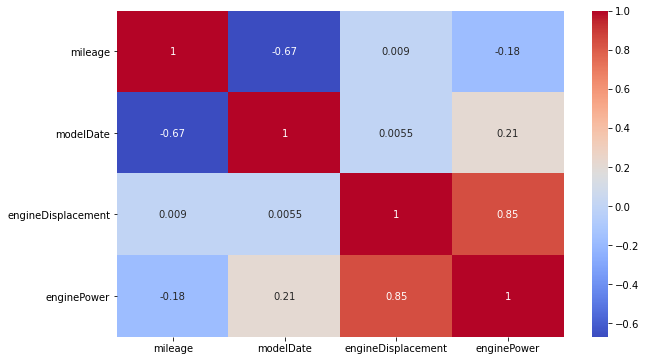

In [2494]:
# Посмотрим корреляцию числовых признаков
num_cols = ['mileage', 'modelDate','engineDisplacement','enginePower']
correlation = cars[num_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

# Label Encoding

In [2495]:
#num_cols = ['mileage', 'engineDisplacement','enginePower']
#for col in num_cols:
#    cars[col] = cars[col].apply(lambda w: np.log(w))

In [2496]:
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate','productionDate']
# логарифмирование
for col in num_cols:
    cars[col] = cars[col].apply(lambda w: np.log(w + 1))
    
# нормирование
scaler = StandardScaler()
cars[num_cols] = scaler.fit_transform(cars[num_cols])

In [2497]:
dum_cols = ['bodyType', 'brand', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'vendor',
           'Владельцы', 'ПТС', 'Привод', 'Руль', 'color', 'brand_country']
cars = pd.get_dummies(cars, columns=dum_cols)
cars.shape

(84205, 93)

In [2498]:
# Кодируем категориальные признаки
cat_cols = ['vehicleConfiguration','model_name']
for col in cat_cols:
    cars[col] = cars[col].astype('category').cat.codes

In [2499]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84205 entries, 0 to 84204
Data columns (total 93 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   engineDisplacement                    84205 non-null  float64
 1   enginePower                           84205 non-null  float64
 2   mileage                               84205 non-null  float64
 3   modelDate                             84205 non-null  float64
 4   model_name                            84205 non-null  int16  
 5   price                                 84205 non-null  int64  
 6   productionDate                        84205 non-null  float64
 7   vehicleConfiguration                  84205 non-null  int16  
 8   sample                                84205 non-null  int64  
 9   kof_price                             84205 non-null  float64
 10  mileage_year                          84205 non-null  int64  
 11  bodyType_внедор

In [2500]:
X_train_test = cars.copy()
X_train_test.head(3)

,engineDisplacement,enginePower,mileage,modelDate,model_name,price,productionDate,vehicleConfiguration,sample,kof_price,...,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,brand_country_Германия,brand_country_Чехия,brand_country_Швеция,brand_country_Япония
0,2.589714,2.022002,-0.148408,0.56376,401,2380000,0.535627,61,1,0.938,...,0,0,0,0,0,1,0,0,0,1
1,2.589714,2.022002,-0.439528,0.56376,401,2700000,0.535627,61,1,0.938,...,0,0,0,0,0,1,0,0,0,1
2,0.316176,0.607966,-0.724099,0.56376,397,1575000,0.535627,36,1,0.938,...,0,0,0,0,0,0,0,0,0,1


In [2501]:
# Разделяем обратно train и test .Удаляем из train со странным пробегом
train = X_train_test.query('sample == 1').drop(['sample','kof_price'], axis=1)
train = train.query('mileage_year > 100 or modelDate > 115')
# Пробуем сделать логарифмирование тергета
#train['price'] = train['price'].apply(lambda w: np.log(w + 1))
y = train.price.values
train2 = train
train = train.drop(['price'], axis=1)
test = X_train_test.query('sample == 0').drop(['sample','price'], axis=1)
X = train
Z = test.kof_price.values
test = test.drop(['kof_price'], axis=1)
owl = X_train_test.query('sample == 0').drop(['sample'], axis=1)

In [2502]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49239 entries, 0 to 49516
Data columns (total 90 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   engineDisplacement                    49239 non-null  float64
 1   enginePower                           49239 non-null  float64
 2   mileage                               49239 non-null  float64
 3   modelDate                             49239 non-null  float64
 4   model_name                            49239 non-null  int16  
 5   productionDate                        49239 non-null  float64
 6   vehicleConfiguration                  49239 non-null  int16  
 7   mileage_year                          49239 non-null  int64  
 8   bodyType_внедорожник 3 дв.            49239 non-null  uint8  
 9   bodyType_внедорожник 5 дв.            49239 non-null  uint8  
 10  bodyType_внедорожник открытый         49239 non-null  uint8  
 11  bodyType_кабрио

In [2503]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 49519 to 84204
Data columns (total 90 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   engineDisplacement                    34686 non-null  float64
 1   enginePower                           34686 non-null  float64
 2   mileage                               34686 non-null  float64
 3   modelDate                             34686 non-null  float64
 4   model_name                            34686 non-null  int16  
 5   productionDate                        34686 non-null  float64
 6   vehicleConfiguration                  34686 non-null  int16  
 7   mileage_year                          34686 non-null  int64  
 8   bodyType_внедорожник 3 дв.            34686 non-null  uint8  
 9   bodyType_внедорожник 5 дв.            34686 non-null  uint8  
 10  bodyType_внедорожник открытый         34686 non-null  uint8  
 11  bodyType_ка

# Train Split

In [2504]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [2505]:
# проверяем
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((34686, 90), (49239, 90), (39391, 90), (39391,), (9848, 90))

In [2506]:
# проверяем
y_test.shape

(9848,)

# MODELS

## Model 1: Создадим "наивную" модель 
**Хорошо наивным быть для сердца, но вредно для ума. (Анатоль Франс)**



Эта модель будет предсказывать среднюю цену по мощности двигателя enginePower. C ней будем сравнивать другие модели.

In [2507]:
tmp_train = train.copy()
tmp_train['price'] = y
#tmp_train = X_train_test.query('sample == 1').drop(['sample','kof_price'], axis=1)

In [2508]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.4f}%")

Точность наивной модели по метрике MAPE: 82.0626%


##  Model 2 : CatBoost

- eval_metric – метрика, используемая для обнаружения переобучения
- Iterations – максимальное количество построенных деревьев, по умолчанию 1000. Альтернативные названия num_boost_round, n_estimators и num_trees
- cat_features — массив с категориальными столбцами.

Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [2509]:
np.log(y_train)

array([14.29608314, 14.21428668, 12.76568843, ..., 13.73212895,
       13.01477817, 12.99453001])

In [2510]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_cols,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2.model')

In [2511]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test))

In [2512]:
print(f"CatBoost. Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.4f}%")

CatBoost. Точность модели по метрике MAPE: 10.5995%


- **CatBoost. Точность модели по метрике MAPE: 10.5673%**
- **score kaggle - 16.82652**

**Поработаем с параметры кодирования категориальных признаков в CatBoost. Приблизительно оценим количество деревьев и требуемую скорость обучения, достаточных для этой задачи.**

In [2513]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [2514]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=5000)

In [2515]:
model.fit(X_train, y_train,
         #cat_features=cat_cols,
         eval_set=(X_test, y_test),
         verbose_eval=2000,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1297432.1984859	test: 1342509.3946527	best: 1342509.3946527 (0)	total: 7.89ms	remaining: 39.4s
2000:	learn: 158418.5827744	test: 269642.7443366	best: 269638.3209004 (1999)	total: 17.3s	remaining: 25.9s
4000:	learn: 119271.7542636	test: 260571.0195725	best: 260571.0195725 (4000)	total: 37s	remaining: 9.24s
4999:	learn: 107468.5393610	test: 257931.3212345	best: 257926.0419389 (4988)	total: 48s	remaining: 0us

bestTest = 257926.0419
bestIteration = 4988

Shrink model to first 4989 iterations.


Функция, которая проверяет производительность CatBoost на трехкратной перекрестной проверке с учетом параметров и возвращает полный список параметров для последней модели. При желании эта функция сравнивает метрики модели с результатами модели, обученной с параметрами категориальных характеристик по умолчанию.
Мы зафиксируем количество оценщиков на 5000 и скорость обучения на 0,1.

In [2516]:
kf = KFold(n_splits=3, shuffle=True)
DEFAULT_PARAMETERS = {'n_estimators' : 5000, 'learning_rate' : 0.1}
DEFAULT_MODEL_METRICS = {}

def score_catboost_model(catboost_parameters, update_defaults=False):
    r2_values = []
    rmse_values = []
    #mape_values = []
    catboost_parameters.update(DEFAULT_PARAMETERS)
    for train_index, test_index in kf.split(train):
        train_pool = Pool(train2.iloc[train_index].drop(['price'], 1),
                          label=train2.iloc[train_index].price,
                          cat_features=cat_cols)
        test_pool = Pool(train2.iloc[test_index].drop(['price'], 1),
                        label=train2.iloc[test_index].price,
                        cat_features=cat_cols)
        model = CatBoost(catboost_parameters)
        model.fit(train_pool, verbose=False)
        
        r2_values.append(r2_score(train2.iloc[test_index].price.values, model.predict(test_pool)))
        rmse_values.append(mean_squared_error(train2.iloc[test_index].price.values,
                                              model.predict(test_pool),
                                              squared=False)) 
    if update_defaults:
        DEFAULT_MODEL_METRICS['R2'] = np.mean(r2_values)
        DEFAULT_MODEL_METRICS['RMSE'] = np.mean(rmse_values)
        print('R2 score: {:.4f}({:.4f})'.format(np.mean(r2_values), np.std(r2_values)))
        print('RMSE score: {:.0f}({:.0f})'.format(np.mean(rmse_values), np.std(rmse_values)))  
    else:
        DEFAULT_MODEL_R2 = DEFAULT_MODEL_METRICS['R2']
        DEFAULT_MODEL_RMSE = DEFAULT_MODEL_METRICS['RMSE']
        r2_change = 100 * (np.mean(r2_values) - DEFAULT_MODEL_R2) / DEFAULT_MODEL_R2
        rmse_change = 100 * (np.mean(rmse_values) - DEFAULT_MODEL_RMSE) / DEFAULT_MODEL_RMSE
        print('R2 score: {:.4f}({:.4f}) {:+.1f}% по сравнению с параметрами по умолчанию'.format(
            np.mean(r2_values), np.std(r2_values), r2_change))
        print('RMSE score: {:.0f}({:.0f}) {:+.1f}% по сравнению с параметрами по умолчанию'.format(
            np.mean(rmse_values), np.std(rmse_values), rmse_change)) 
              
    return model.get_all_params()

In [2517]:
# Cохраним метрики модели с параметрами категориальных признаков по умолчанию для дальнейшего сравнения.
last_model_params = score_catboost_model({}, True)

R2 score: 0.9497(0.0033)
RMSE score: 315043(8273)


In [2518]:
last_model_params

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCou

In [2519]:
np.log(y_train)

array([14.29608314, 14.21428668, 12.76568843, ..., 13.73212895,
       13.01477817, 12.99453001])

In [2520]:
model = CatBoost(last_model_params)
model.fit(X_train, np.log(y_train),
         #cat_features=cat_cols,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [2521]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test))

In [2522]:
print(f"CatBoost. Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.4f}%")

CatBoost. Точность модели по метрике MAPE: 9.3555%


- **CatBoost. Точность модели по метрике MAPE: 9.2861%**
- **CatBoost. Score kaggle (по умолчанию) 16.95450**

#### **Попытаемся заставить CatBoost использовать горячую кодировку для всех наших категориальных функций (максимальная мощность категориальной функции  <2000). В документации говорится, что для функций, для которых используется горячая кодировка, другие кодировки не вычисляются.**

In [2523]:
cat_cols = ['model_name', 'vehicleConfiguration', 'bodyType_внедорожник 3 дв.',
            'bodyType_внедорожник 5 дв.', 'bodyType_внедорожник открытый',
            'bodyType_кабриолет', 'bodyType_компактвэн', 'bodyType_купе',
            'bodyType_купе-хардтоп', 'bodyType_лимузин', 'bodyType_лифтбек',
            'bodyType_микровэн', 'bodyType_минивэн',
            'bodyType_пикап двойная кабина', 'bodyType_пикап одинарная кабина',
            'bodyType_пикап полуторная кабина', 'bodyType_родстер',
            'bodyType_седан', 'bodyType_седан 2 дв.', 'bodyType_седан-хардтоп',
            'bodyType_тарга', 'bodyType_универсал 3 дв.',
            'bodyType_универсал 5 дв.', 'bodyType_фургон', 'bodyType_хэтчбек 3 дв.',
            'bodyType_хэтчбек 5 дв.', 'brand_AUDI', 'brand_BMW', 'brand_HONDA',
            'brand_INFINITI', 'brand_LEXUS', 'brand_MERCEDES', 'brand_MITSUBISHI',
            'brand_NISSAN', 'brand_SKODA', 'brand_TOYOTA', 'brand_VOLKSWAGEN',
            'brand_VOLVO', 'fuelType_бензин', 'fuelType_газ', 'fuelType_гибрид',
            'fuelType_дизель', 'fuelType_электро', 'numberOfDoors_0',
            'numberOfDoors_2', 'numberOfDoors_3', 'numberOfDoors_4',
            'numberOfDoors_5', 'vehicleTransmission_автоматическая',
            'vehicleTransmission_вариатор', 'vehicleTransmission_механическая',
            'vehicleTransmission_роботизированная', 'vendor_0', 'vendor_1',
            'Владельцы_1', 'Владельцы_2', 'Владельцы_3', 'ПТС_0', 'ПТС_1',
            'Привод_задний', 'Привод_передний', 'Привод_полный', 'Руль_0', 'Руль_1',
            'color_бежевый', 'color_белый', 'color_голубой', 'color_жёлтый',
            'color_зелёный', 'color_золотистый', 'color_коричневый',
            'color_красный', 'color_оранжевый', 'color_пурпурный', 'color_розовый',
            'color_серебристый', 'color_серый', 'color_синий', 'color_фиолетовый',
            'color_чёрный', 'brand_country_Германия', 'brand_country_Чехия',
            'brand_country_Швеция', 'brand_country_Япония']

In [2524]:
model_params

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2000,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorder

In [2525]:
np.log(y_train)
model = CatBoost(model_params)
model.fit(X_train, np.log(y_train),
         cat_features=cat_cols,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [2526]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test))

In [2527]:
print(f"CatBoost. Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.4f}%")

CatBoost. Точность модели по метрике MAPE: 9.9780%


- **CatBoost. Точность модели по метрике MAPE: 10.0381%**
- **CatBoost.Score kaggle (категориальные признаки) - 16.94711**

## Model 3. Random Forest

**Дерево - это непостижимая загадка. (Джим Вудринг).**

In [2528]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [2529]:
# проверяем
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((34686, 90), (49239, 90), (39391, 90), (39391,), (9848, 90))

In [2530]:
# проверяем
y_test.shape

(9848,)

In [2531]:
np.log(y_train)

array([14.29608314, 14.21428668, 12.76568843, ..., 13.73212895,
       13.01477817, 12.99453001])

In [2532]:
# Создаём модель параметры леса по умолчанию
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.9s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [2533]:
predict_test = model.predict(X_test)
predict_submission = model.predict(test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [2534]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


In [2535]:
print(f"Random Forest. Точность модели по метрике MAPE: {mape(y_test, predict_test)*100:0.4f}%")

Random Forest. Точность модели по метрике MAPE: 7.5797%


- **Random Forest. Точность модели по метрике MAPE: 7.5816%**
- **Random Forest. Score kaggle - 17.76663**

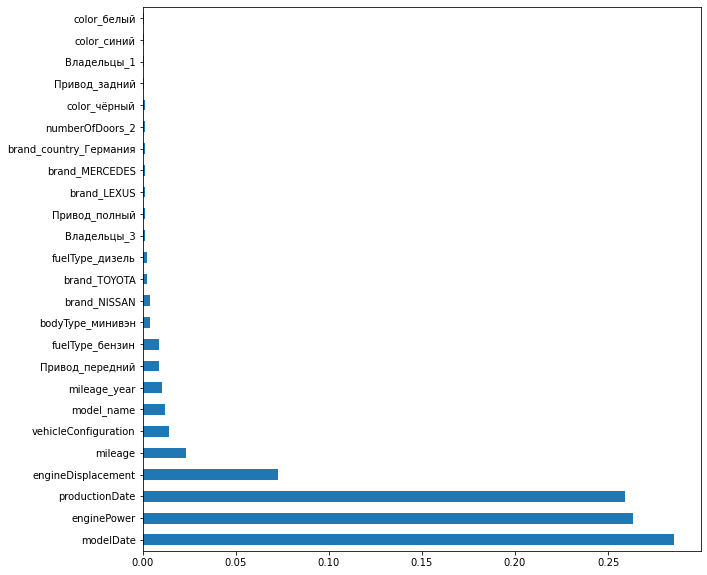

In [2536]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

## Model 4. Bagging

In [2537]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [2538]:
# проверяем
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((34686, 90), (49239, 90), (39391, 90), (39391,), (9848, 90))

In [2539]:
# Посмотрим сначала на точность одного дерева
tree = DecisionTreeRegressor(max_features=int(X_train.shape[1]/3), max_depth=200)
tree.fit(X_train, y_train)
test_predict = tree.predict(X_test)
print(f"Bagging. Точность модели по метрике MAPE: {mape(y_test, test_predict)*100:0.4f}%")

Bagging. Точность модели по метрике MAPE: 8.3201%


In [2540]:
# Теперь обернем деревья в BaggingRegressor
bagging_trees = BaggingRegressor(tree)
bagging_trees.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=200,
                                                      max_features=30))

In [2541]:
predict_test = bagging_trees.predict(X_test)
predict_submission = bagging_trees.predict(test)

In [2542]:
print(f"BaggingRegressor(DecisionTrees) Точность модели по метрике MAPE:  {mape(y_test, predict_test)*100:0.4f}%")

BaggingRegressor(DecisionTrees) Точность модели по метрике MAPE:  8.9266%


- **BaggingRegressor(DecisionTrees) Точность модели по метрике MAPE:  9.1668%**
- **Score kaggle 19.70274**

## Model 5: Stacking with RandomForestRegressor

In [2543]:
# Делим train для обучения и проверки моделей
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Будем брать среднее.

In [2544]:
models = [RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in tqdm(d_models):
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = y_pred               
    return d_df

temp_df = stacking_model_predict(models, X_train, y_train, X_test)
temp_df['y_pred']=temp_df.mean(axis=1)

predict = np.array(temp_df['y_pred'])

# # оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.4f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



Точность модели по метрике MAPE: 8.3452%


In [2545]:
# Обучим еще раз теперь на всем датасете
temp_df = stacking_model_predict(models, X, y, test)
temp_df['y_pred']=temp_df.mean(axis=1)

predict_submission = np.array(temp_df['y_pred'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


**Stacking with RandomForestRegressor. Score 18.68196**

# Submission

In [2546]:
owl['price'] = predict_submission
owl['price_new'] = round(owl['price'] * owl['kof_price'],0)
predict_submission = np.array(owl['price_new'])
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,639328.0
1,1100549428,905732.0
2,1100658222,810564.0
3,1100937408,748066.0
4,1101037972,784807.0
5,1100912634,690425.0
6,1101228730,668707.0
7,1100165896,389772.0
8,1100768262,1945973.0
9,1101218501,767933.0


# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing